In [7]:
from aleatory.processes import GBM 
from aleatory.utils.utils import draw_paths
import numpy as np

In [8]:
r = 0.02
sigma = 0.15
x0 = 1.0
T = 6
N = 50
n = 20*6
gbm = GBM(initial=x0, drift=r, volatility=sigma, T=T)
paths = gbm.simulate(n=n, N=N) 

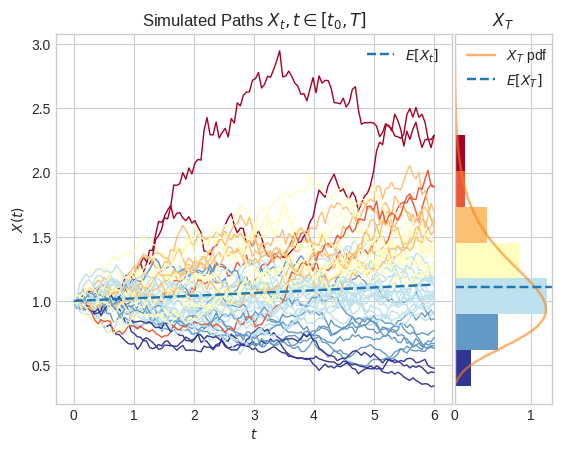

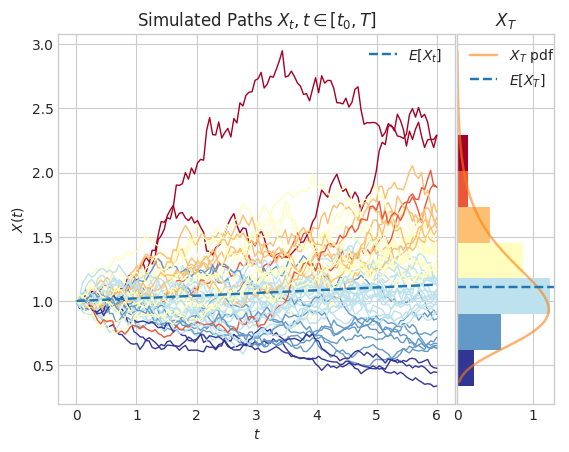

In [9]:
times = gbm.times
expectations = gbm.marginal_expectation(times)
marginalT = gbm.get_marginal(5.0)
X = np.stack(paths, axis=1)
draw_paths(times=times, paths=paths, N=N, expectations=expectations,marginalT=marginalT, marginal=True)

In [10]:
l =[]
l[:1]

[]

In [12]:
def merge(nums1, m, nums2, n):
    """
        :type nums1: List[int]
        :type m: int
        :type nums2: List[int]
        :type n: int
        :rtype: None Do not return anything, modify nums1 in-place instead.
    """
    nums1 = nums1[:m]
    nums2 = nums2[:n]
    c= np.concatenate((nums1,nums2))
    return np.sort(c)

In [13]:
nums1 =[1,2,3,0,0,0]
m = 3
nums2 =[2,5,6]
n= 3
merge(nums1,m,nums2,n)

array([1, 2, 2, 3, 5, 6])

In [5]:
n= 5 
list(range(n-1,-1,-1))

[4, 3, 2, 1, 0]

In [10]:
import scipy.stats as ss
import numpy as np

In [ ]:
def mvt(t):
    if t==:
        return 250
    
